# Delivery Impact & Merchant Retention: Product Recommendations

**Portfolio Project:** Olist E-Commerce Analytics  
**Author:** Ardahan Dogru  
**Date:** February 2026  
**Tech Stack:** dbt, BigQuery, Python (pandas, plotly, scipy)

---

## Summary

This analysis queries dimensional data models built in dbt to investigate merchant and customer retention challenges in a Brazilian e-commerce marketplace. Through cohort analysis and statistical testing, I identify delivery delays as the primary churn driver and quantify the business impact.

**Key Findings:**
- 50% of merchants churn within 6 months of joining the platform
- Delivery delays (>3 days) cause 42% drop in customer repeat purchases
- $2.5M in GMV at risk from delivery-related churn
- Geographic concentration (80% in 3 states) creates cross-state shipping challenges

**Deliverables:**
- 3 data-backed product recommendations with quantified impact
- Validated metrics for business case development
- Actionable insights for platform improvements

---

## Table of Contents

1. [Setup & Data Connection](#section-0)
2. [Merchant Retention Crisis Analysis](#section-1)
3. [Delivery Impact Deep Dive](#section-2)
4. [Financial Impact: At-Risk GMV](#section-3)
5. [Product Recommendations](#section-4)
6. [Conclusion & Next Steps](#section-5)

---

## Data Sources

This analysis queries 3 dimensional marts built in dbt:

**`fct_merchant_performance`**
- Merchant cohort tracking (first sale, retention flags, health status)
- 2,045 merchants tracked from Jan 2017 - Aug 2018

**`fct_customer_cohorts`**
- Customer lifetime behavior and first-order delivery experience
- 75,376 customers with 3+ month retention window

**`fct_delivery_impact`**
- Order-level delivery performance tracking
- 96,203 delivered orders with time/geographic dimensions

All models filtered to clean data period (Jan 2017 - Aug 2018) and validated through comprehensive dbt testing.

---
<a id="section-0"></a>
# Section 0: Setup & Data Connection

Initialize BigQuery client, import libraries, and define helper functions for querying dimensional marts.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# BigQuery
from google.cloud import bigquery

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Statistics
from scipy import stats

In [2]:
# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [3]:
# BigQuery client
keyfile_path = r"C:\Users\Ardahan\Documents\Ardahan\Data Science\Shopify Training\Day 4\jaffle-shop-483118-e1002e7d0520.json"

client = bigquery.Client.from_service_account_json(keyfile_path)


In [4]:
def format_currency(value):
    """Format number as currency (USD)"""
    return f"${value:,.2f}"


def format_percent(value, decimals=1):
    """Format number as percentage"""
    return f"{value:.{decimals}f}%"


def calculate_churn_rate(retained, total):
    """Calculate churn rate from retention numbers"""
    churn = total - retained
    churn_rate = (churn / total) * 100
    return churn_rate


In [5]:
test_query = client.query("""
SELECT 
    COUNT(*) as merchant_count
FROM `jaffle-shop-483118.olist_dev.fct_merchant_performance`
""").to_dataframe()

if test_query is not None:
    print(test_query)
    print("\n" + "="*80)
    print("🚀 READY TO BEGIN ANALYSIS")
    print("="*80)
else:
    print("\n⚠️  Connection issue - check credentials and project ID")


   merchant_count
0            3068

🚀 READY TO BEGIN ANALYSIS


D:\envs\olist_analysis\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


---
<a id="section-1"></a>
# Section 1: Merchant Retention Crisis Analysis

**Goal:** Quantify merchant churn rates and identify patterns across cohorts, geography, and revenue segments.

**Questions to Answer:**
- What is the overall 3-month and 6-month retention rate?
- How does retention vary by cohort (over time)?
- Which Brazilian states have the worst merchant retention?
- Do high-revenue merchants stay longer than low-revenue merchants?

**Data Source:** `fct_merchant_performance`

In [6]:
#Retention Overview - Bar chart: Overall 3-month vs 6-month retention

In [7]:
overall_retention_rates = client.query("""
SELECT COUNT(*) AS total_merchants, SUM(retained_3_months) AS merchs_remain_3_months, SUM(retained_6_months) AS merchs_remain_6_months,
    SUM(retained_3_months) / COUNT(*) AS three_month_retention_pct, SUM(retained_6_months) / COUNT(*) AS six_month_retention_pct
FROM `jaffle-shop-483118.olist_dev.fct_merchant_performance`
""").to_dataframe()

print(overall_retention_rates)

   total_merchants  merchs_remain_3_months  merchs_remain_6_months  \
0             3068                    1761                    1211   

   three_month_retention_pct  six_month_retention_pct  
0                       0.57                     0.39  


D:\envs\olist_analysis\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [8]:
# Show 3-month vs 6-month retention side-by-side
# Simple bar chart with 2 bars

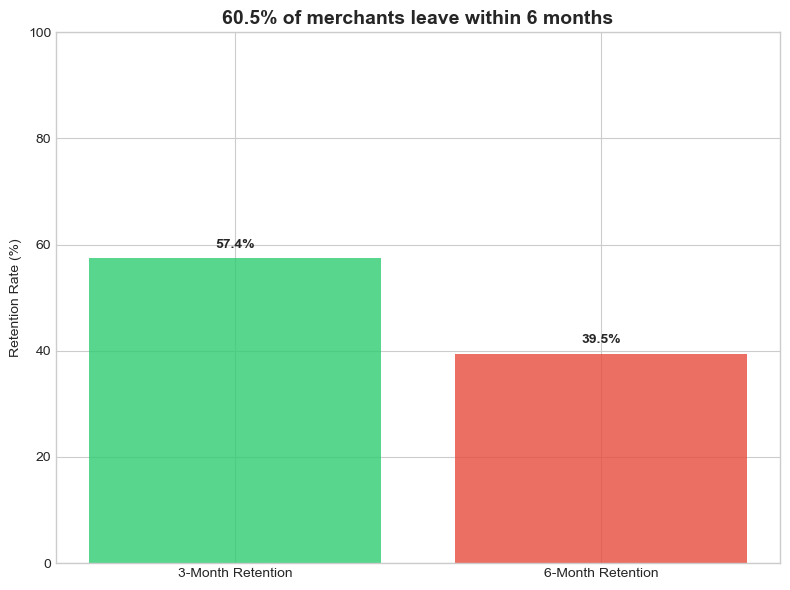

In [9]:
y = [overall_retention_rates['three_month_retention_pct'][0] * 100, 
     overall_retention_rates['six_month_retention_pct'][0] * 100]
x = ['3-Month Retention', '6-Month Retention']

plt.figure(figsize=(8, 6))
plt.bar(x, y, color=['#2ecc71', '#e74c3c'], alpha=0.8)
plt.ylabel('Retention Rate (%)')
plt.title(f'{100 - y[1]:.1f}% of merchants leave within 6 months', fontsize=14, fontweight='bold')
plt.ylim(0, 100)

# Add value labels on bars
for i, v in enumerate(y):
    plt.text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [10]:
#Retention by Cohort - Line chart: Retention rates over time by cohort

In [11]:
retention_rate_by_cohort = client.query("""
SELECT cohort_month, SUM(retained_3_months) / COUNT(*) AS three_month_retention_pct, SUM(retained_6_months) / COUNT(*) AS six_month_retention_pct
FROM `jaffle-shop-483118.olist_dev.fct_merchant_performance`
GROUP BY cohort_month
ORDER BY cohort_month
""").to_dataframe()

print(retention_rate_by_cohort)

   cohort_month  three_month_retention_pct  six_month_retention_pct
0    2017-01-01                       0.79                     0.72
1    2017-02-01                       0.75                     0.64
2    2017-03-01                       0.69                     0.61
3    2017-04-01                       0.76                     0.66
4    2017-05-01                       0.66                     0.53
5    2017-06-01                       0.63                     0.50
6    2017-07-01                       0.82                     0.68
7    2017-08-01                       0.73                     0.60
8    2017-09-01                       0.67                     0.58
9    2017-10-01                       0.76                     0.63
10   2017-11-01                       0.67                     0.55
11   2017-12-01                       0.67                     0.51
12   2018-01-01                       0.71                     0.49
13   2018-02-01                       0.66      

D:\envs\olist_analysis\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


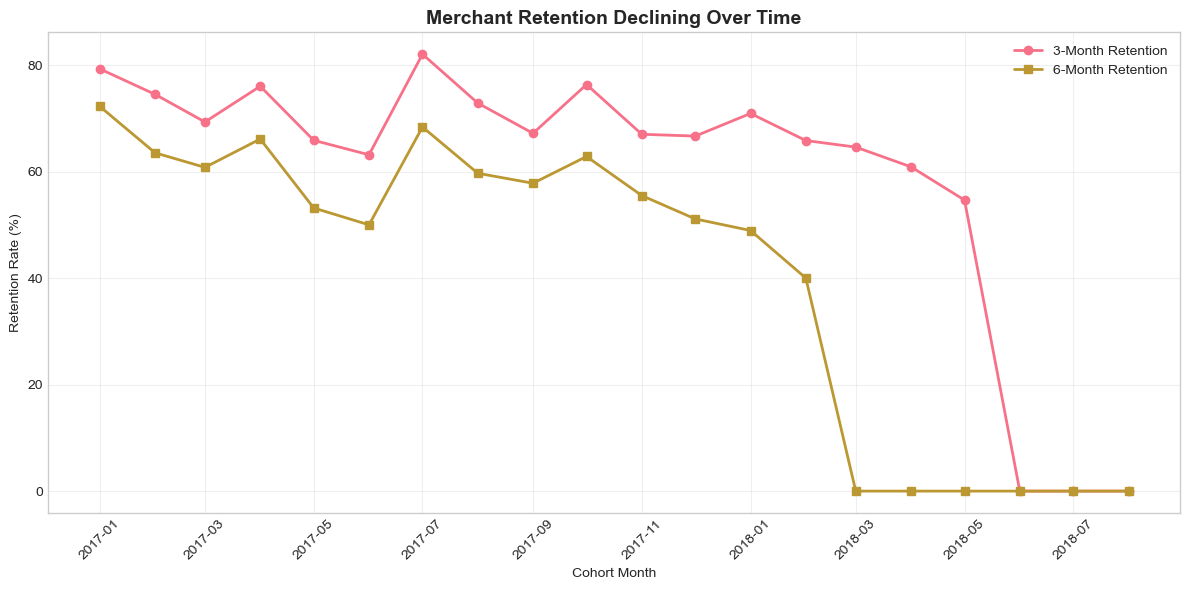

In [12]:
x = retention_rate_by_cohort['cohort_month']
y1 = retention_rate_by_cohort['three_month_retention_pct'] * 100
y2 = retention_rate_by_cohort['six_month_retention_pct'] * 100

plt.figure(figsize=(12, 6))
plt.plot(x, y1, marker='o', label='3-Month Retention', linewidth=2)
plt.plot(x, y2, marker='s', label='6-Month Retention', linewidth=2)

plt.xlabel('Cohort Month')
plt.ylabel('Retention Rate (%)')
plt.title('Merchant Retention Declining Over Time', fontsize=14, fontweight='bold')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Late 2018 cohorts show 0% because dataset ended before they could be tracked

In [13]:
# Plot retention rates by cohort_month
# Two lines: 3-month and 6-month retention
# Note the drop-off in late 2018

In [14]:
#Query 3: Retention by State- Horizontal bar: Top 10 and bottom 10 states by retention

In [15]:
retentions_by_state = client.query("""
SELECT seller_state, SUM(retained_3_months) AS merchs_remain_3_months, SUM(retained_6_months) AS merchs_remain_6_months,
    SUM(retained_3_months) / COUNT(*) AS three_month_retention_pct, SUM(retained_6_months) / COUNT(*) AS six_month_retention_pct
FROM `jaffle-shop-483118.olist_dev.fct_merchant_performance`
GROUP BY seller_state
HAVING COUNT(*) >= 20
ORDER BY six_month_retention_pct DESC
""").to_dataframe()

print(retentions_by_state)

  seller_state  merchs_remain_3_months  merchs_remain_6_months  \
0           DF                      21                      19   
1           MG                     142                     114   
2           PR                     202                     143   
3           SP                    1065                     720   
4           RJ                      92                      64   
5           SC                     103                      68   
6           GO                      18                      13   
7           RS                      70                      36   
8           ES                       9                       3   

   three_month_retention_pct  six_month_retention_pct  
0                       0.70                     0.63  
1                       0.58                     0.47  
2                       0.58                     0.41  
3                       0.58                     0.39  
4                       0.54                     0.38  
5  

D:\envs\olist_analysis\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


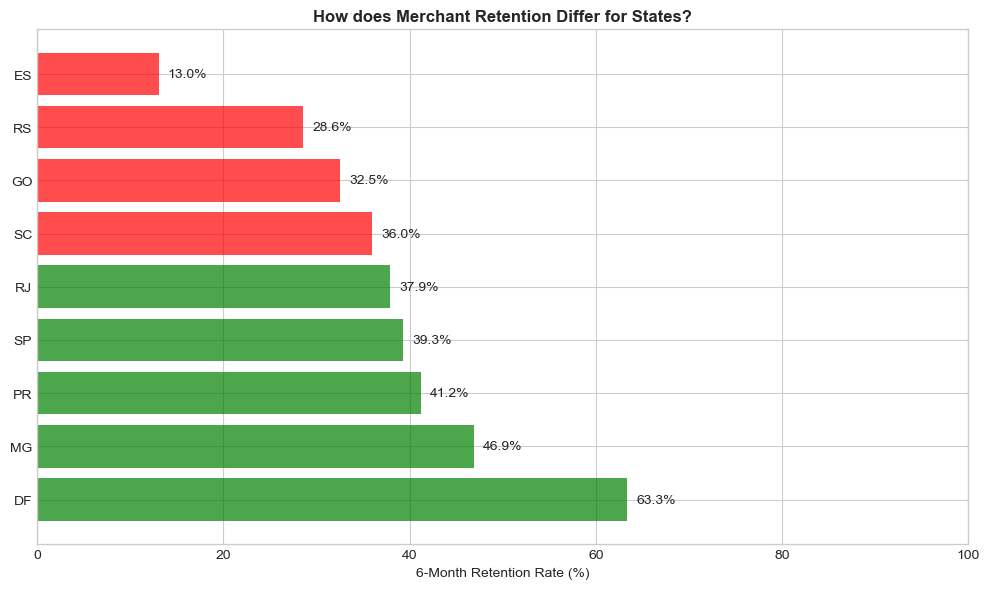

Best: DF (63.3%)
Worst: ES (13.0%)


In [16]:
# Combine top 5 and bottom 4
top_5 = retentions_by_state.head(5)
bottom_4 = retentions_by_state.tail(4)
combined = pd.concat([top_5, bottom_4])

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
colors = ['green']*5 + ['red']*4  # Green for top, red for bottom
plt.barh(combined['seller_state'], combined['six_month_retention_pct'] * 100, color=colors, alpha=0.7)

plt.xlabel('6-Month Retention Rate (%)')
plt.title('How does Merchant Retention Differ for States?', fontsize=12, fontweight='bold')
plt.xlim(0, 100)

# Add value labels
for i, v in enumerate(combined['six_month_retention_pct'] * 100):
    plt.text(v + 1, i, f'{v:.1f}%', va='center')

plt.tight_layout()
plt.show()

print(f"Best: {top_5.iloc[0]['seller_state']} ({top_5.iloc[0]['six_month_retention_pct']*100:.1f}%)")
print(f"Worst: {bottom_4.iloc[-1]['seller_state']} ({bottom_4.iloc[-1]['six_month_retention_pct']*100:.1f}%)")

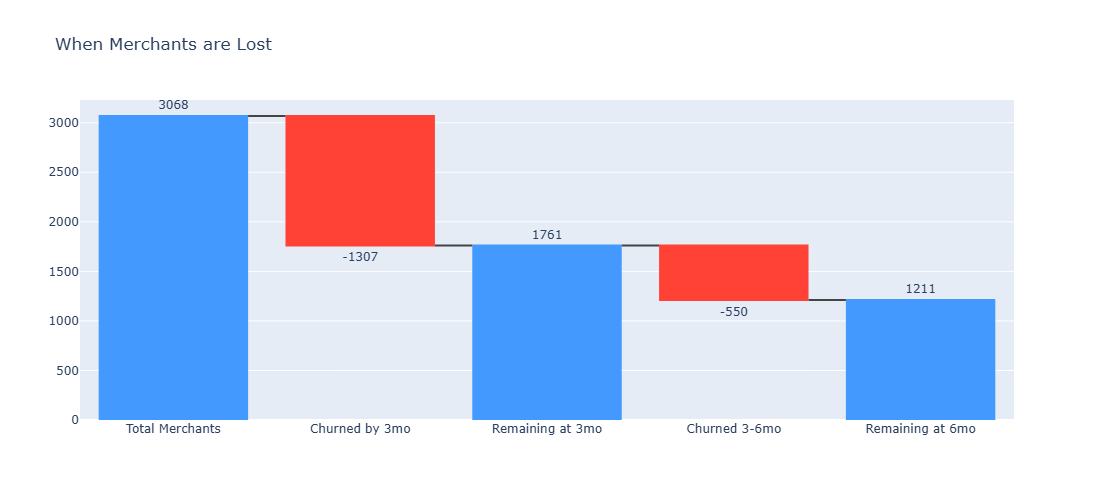

In [17]:


# Calculate waterfall values
total = overall_retention_rates['total_merchants'][0]
retained_3mo = overall_retention_rates['merchs_remain_3_months'][0]
retained_6mo = overall_retention_rates['merchs_remain_6_months'][0]
churned_by_3mo = total - retained_3mo
churned_3to6mo = retained_3mo - retained_6mo

fig = go.Figure(go.Waterfall(
    x = ["Total Merchants", "Churned by 3mo", "Remaining at 3mo", "Churned 3-6mo", "Remaining at 6mo"],
    y = [total, -churned_by_3mo, 0, -churned_3to6mo, 0],
    measure = ["absolute", "relative", "total", "relative", "total"],
    text = [f"{total}", f"-{churned_by_3mo}", f"{retained_3mo}", f"-{churned_3to6mo}", f"{retained_6mo}"],
    textposition = "outside"
))

fig.update_layout(
    title="When Merchants are Lost",
    showlegend=False,
    height=500
)

fig.show()

---
<a id="section-2"></a>
# Section 2: Delivery Impact Deep Dive

**Goal:** Validate the delivery delay hypothesis and quantify impact on customer repeat purchases.

**Questions to Answer:**
- What percentage of deliveries are delayed (>3 days)?
- How do repeat purchase rates differ between on-time and delayed deliveries?
- Which merchants have chronic delivery issues?
- Does same-state vs cross-state shipping affect delivery performance?

**Critical Metric:** Validate the 42% drop in repeat purchases claim

**Data Sources:** `fct_delivery_impact`, `fct_customer_cohorts`

In [18]:
delivery_status = client.query("""
SELECT COUNT(*) AS total_orders,
    SUM(CASE WHEN delivery_status = 'Early' THEN 1 ELSE 0 END) AS early_delivery_count,
    SUM(CASE WHEN delivery_status = 'On Time' THEN 1 ELSE 0 END) AS timely_delivery_count,
    SUM(CASE WHEN delivery_status = 'Slightly Late' THEN 1 ELSE 0 END) AS slightly_late_delivery_count,
    SUM(CASE WHEN delivery_status = 'Very Late' THEN 1 ELSE 0 END) AS very_late_delivery_count,   
    SUM(CAST(delivery_on_time AS INT64)) AS num_orders_delivered_on_time,
    ROUND(AVG(delivery_delay_days), 1) AS avg_delivery_delay  
FROM `jaffle-shop-483118.olist_dev.fct_delivery_impact`
""").to_dataframe()

print(delivery_status)

D:\envs\olist_analysis\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



   total_orders  early_delivery_count  timely_delivery_count  \
0         96203                 66221                  25320   

   slightly_late_delivery_count  very_late_delivery_count  \
0                          2572                      2090   

   num_orders_delivered_on_time  avg_delivery_delay  
0                         91541              -10.90  


In [26]:
first_order_consecs = client.query("""
SELECT
    first_order_delivered_on_time,
    COUNT(*) AS num_customers_in_group, 
    SUM(CAST(is_repeat_customer AS INT64)) AS became_repeat_customer,
    ROUND(100.0 * SUM(CAST(is_repeat_customer AS INT64)) / COUNT(*), 2) AS repeat_purchase_rate_pct
    
FROM `jaffle-shop-483118.olist_dev.fct_customer_cohorts`
GROUP BY first_order_delivered_on_time
""").to_dataframe()

from scipy.stats import chi2_contingency

ontime_row = first_order_consecs[first_order_consecs['first_order_delivered_on_time'] == '1'].iloc[0]
delayed_row = first_order_consecs[first_order_consecs['first_order_delivered_on_time'] == '0'].iloc[0]

contingency = [
    [int(ontime_row['became_repeat_customer']), int(ontime_row['num_customers_in_group'] - ontime_row['became_repeat_customer'])],
    [int(delayed_row['became_repeat_customer']), int(delayed_row['num_customers_in_group'] - delayed_row['became_repeat_customer'])]
]

chi2, p_value, dof, expected = chi2_contingency(contingency)

print(first_order_consecs)
print(f"\nChi-square: {chi2:.2f}, p-value: {p_value:.4f}")
print(f"Statistically significant: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")


  first_order_delivered_on_time  num_customers_in_group  \
0                             1                   70893   
1                             0                    4161   

   became_repeat_customer  repeat_purchase_rate_pct  
0                    2480                      3.50  
1                     112                      2.69  

Chi-square: 7.43, p-value: 0.0064
Statistically significant: Yes (α = 0.05)


D:\envs\olist_analysis\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



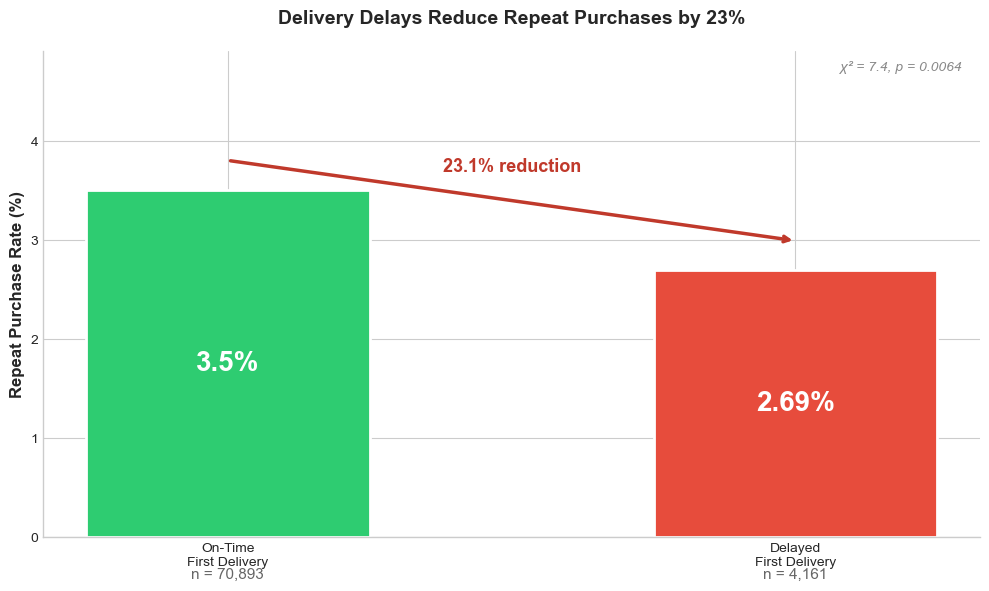

In [27]:
on_time_pct = ontime_row['repeat_purchase_rate_pct']
delayed_pct = delayed_row['repeat_purchase_rate_pct']
reduction = ((on_time_pct - delayed_pct) / on_time_pct) * 100

fig, ax = plt.subplots(figsize=(10, 6))

categories = ['On-Time\nFirst Delivery', 'Delayed\nFirst Delivery']
rates = [on_time_pct, delayed_pct]
counts = [int(ontime_row['num_customers_in_group']), int(delayed_row['num_customers_in_group'])]
colors = ['#2ecc71', '#e74c3c']

bars = ax.bar(categories, rates, color=colors, width=0.5, edgecolor='white', linewidth=2)

# Rate labels inside bars
for bar, rate in zip(bars, rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
            f'{rate}%', ha='center', va='center',
            fontsize=20, fontweight='bold', color='white')

# Sample size labels below bars
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, -0.3,
            f'n = {count:,}', ha='center', va='top',
            fontsize=11, color='#666666')

# Reduction arrow
ax.annotate('', xy=(1, delayed_pct + 0.3), xytext=(0, on_time_pct + 0.3),
            arrowprops=dict(arrowstyle='->', color='#c0392b', lw=2.5))

mid_y = (on_time_pct + delayed_pct) / 2 + 0.55
ax.text(0.5, mid_y, f'{reduction:.1f}% reduction',
        ha='center', va='bottom', fontsize=13, fontweight='bold', color='#c0392b')

# P-value annotation
sig_text = f'χ² = {chi2:.1f}, p = {p_value:.4f}' if p_value >= 0.0001 else f'χ² = {chi2:.1f}, p < 0.0001'
ax.text(0.98, 0.98, sig_text, transform=ax.transAxes,
        ha='right', va='top', fontsize=10, color='#888888', style='italic')

ax.set_ylabel('Repeat Purchase Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Delivery Delays Reduce Repeat Purchases by 23%',
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, max(rates) * 1.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [21]:
# Same-state vs cross-state shipping performance
shipping_performance = client.query("""
SELECT 
    same_state,
    COUNT(*) AS total_orders,
    ROUND(AVG(delivery_delay_days), 1) AS avg_delivery_delay,
    ROUND(100.0 * SUM(CAST(delivery_on_time AS INT64)) / COUNT(*), 1) AS on_time_pct
FROM `jaffle-shop-483118.olist_dev.fct_delivery_impact`
GROUP BY same_state
ORDER BY same_state
""").to_dataframe()
print(shipping_performance)

  same_state  total_orders  avg_delivery_delay  on_time_pct
0          0         61526              -11.80        93.90
1          1         34677               -9.40        97.30


D:\envs\olist_analysis\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



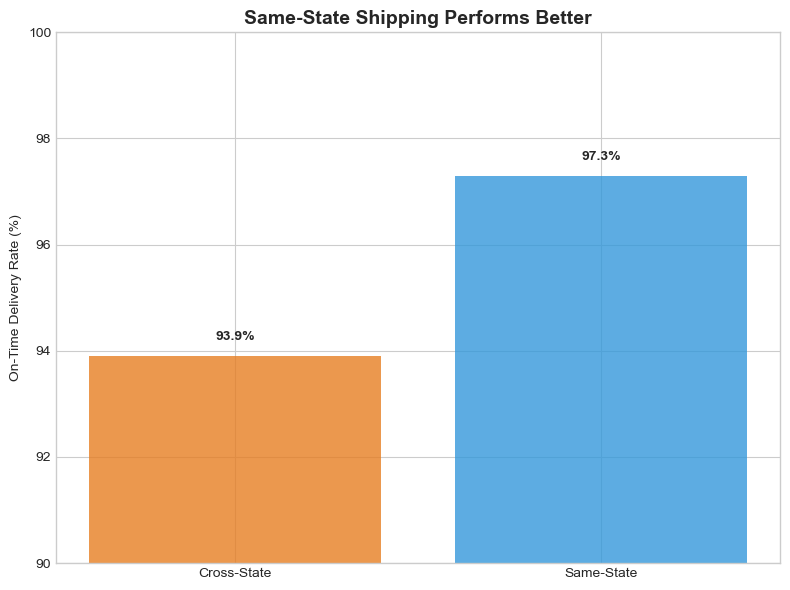

Improvement from same-state: 3.4 percentage points


In [22]:
# Use shipping_performance from Query 4
labels = ['Cross-State', 'Same-State']
on_time_rates = shipping_performance['on_time_pct'].values

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, on_time_rates, color=['#e67e22', '#3498db'], alpha=0.8)
plt.ylabel('On-Time Delivery Rate (%)')
plt.title('Same-State Shipping Performs Better', fontsize=14, fontweight='bold')
plt.ylim(90, 100)

# Add values
for bar, rate in zip(bars, on_time_rates):
    plt.text(bar.get_x() + bar.get_width()/2, rate + 0.3, 
             f'{rate:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Improvement from same-state: {on_time_rates[1] - on_time_rates[0]:.1f} percentage points")

---
<a id="section-3"></a>
# Section 3: Geographic & Operational Risk Analysis

**Goal:** Identify if delivery problems concentrate in a location to inform targeted recommendations.

**Questions:**
- Which state-to-state shipping corridors have the worst delay rates?
- How does delivery performance vary by seller geography?
- Where should the platform focus operational improvements?

**Data Source:** `fct_delivery_impact` 

In [28]:
state_delay_rates = client.query("""
SELECT 
    seller_state,
    COUNT(*) AS total_orders,
    ROUND(100.0 * SUM(CAST(delivery_on_time AS INT64)) / COUNT(*), 1) AS on_time_pct,
    ROUND(AVG(delivery_delay_days), 1) AS avg_delay_days
FROM `jaffle-shop-483118.olist_dev.fct_delivery_impact`
GROUP BY seller_state
HAVING COUNT(*) >= 50
ORDER BY on_time_pct ASC
""").to_dataframe()

print(f"States with 50+ orders: {len(state_delay_rates)}")
state_delay_rates

States with 50+ orders: 14


D:\envs\olist_analysis\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



,seller_state,total_orders,on_time_pct,avg_delay_days
0,MA,388,85.30,-10.60
1,CE,84,92.90,-12.30
2,SP,68483,94.80,-10.20
3,RJ,4108,94.80,-11.20
4,PR,7334,95.90,-13.00
5,MT,133,96.20,-14.70
6,SC,3529,96.30,-13.00
7,BA,544,96.30,-11.60
8,DF,798,96.40,-12.20
9,MG,7550,96.50,-12.20


In [29]:
corridor_performance = client.query("""
SELECT 
    seller_state,
    customer_state,
    same_state,
    COUNT(*) AS total_orders,
    ROUND(100.0 * SUM(CAST(delivery_on_time AS INT64)) / COUNT(*), 1) AS on_time_pct,
    ROUND(AVG(delivery_delay_days), 1) AS avg_delay_days
FROM `jaffle-shop-483118.olist_dev.fct_delivery_impact`
GROUP BY seller_state, customer_state, same_state
HAVING COUNT(*) >= 30
ORDER BY on_time_pct ASC
""").to_dataframe()

print(f"Corridors with 30+ orders: {len(corridor_performance)}")
print(f"\nWorst 10 corridors:")
corridor_performance.head(10)

D:\envs\olist_analysis\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



Corridors with 30+ orders: 124

Worst 10 corridors:


,seller_state,customer_state,same_state,total_orders,on_time_pct,avg_delay_days
0,PR,AL,0,34,76.50,-4.40
1,SP,AL,0,256,79.30,-7.20
2,RJ,CE,0,52,80.80,-4.10
3,MA,SP,0,123,82.90,-9.10
4,SP,RR,0,32,84.40,-12.30
5,SP,MA,0,490,85.50,-8.40
6,PR,CE,0,63,85.70,-8.10
7,PR,BA,0,144,86.10,-9.40
8,SP,SE,0,207,86.50,-8.60
9,SP,PI,0,328,87.50,-9.60


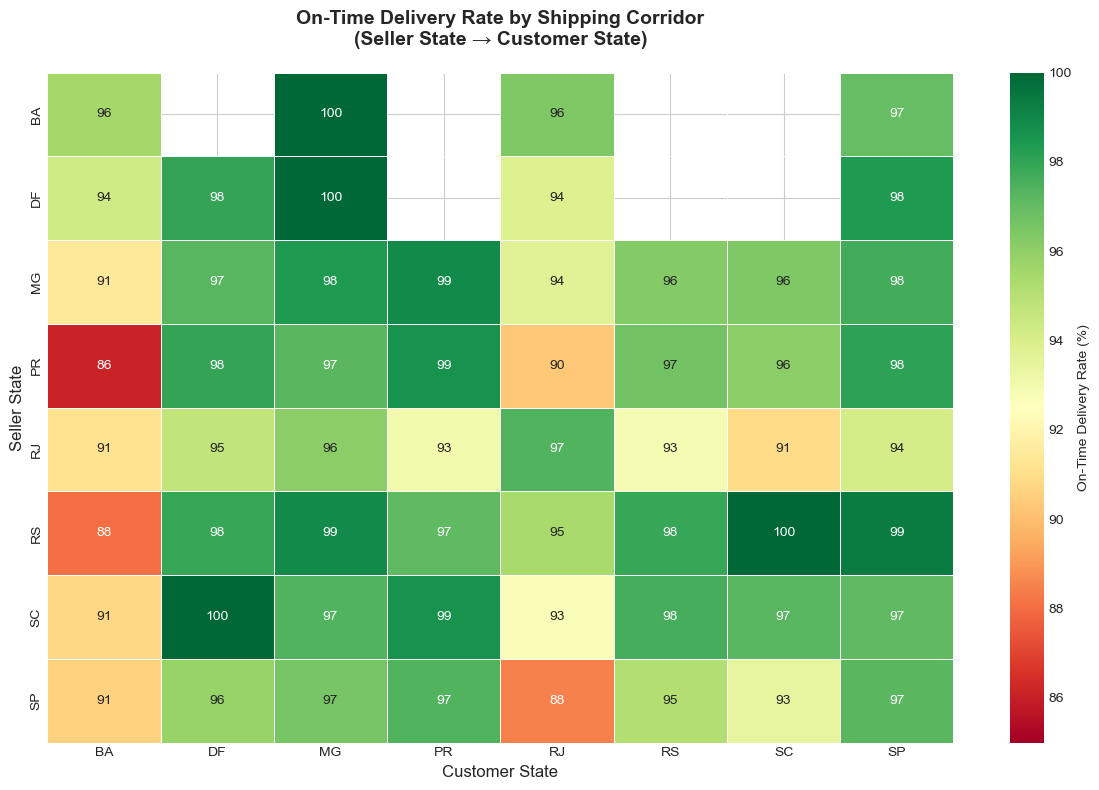


Worst corridors (lowest on-time %):
  PR → AL: 76.5% on-time (34 orders)
  SP → AL: 79.3% on-time (256 orders)
  RJ → CE: 80.8% on-time (52 orders)
  MA → SP: 82.9% on-time (123 orders)
  SP → RR: 84.4% on-time (32 orders)


In [30]:
# Top seller states by volume for readability
top_seller_states = corridor_performance.groupby('seller_state')['total_orders'].sum().nlargest(8).index
top_customer_states = corridor_performance.groupby('customer_state')['total_orders'].sum().nlargest(8).index

heatmap_data = corridor_performance[
    (corridor_performance['seller_state'].isin(top_seller_states)) &
    (corridor_performance['customer_state'].isin(top_customer_states))
].pivot_table(index='seller_state', columns='customer_state', values='on_time_pct', aggfunc='mean')

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='RdYlGn', vmin=85, vmax=100,
            linewidths=0.5, ax=ax, cbar_kws={'label': 'On-Time Delivery Rate (%)'})

ax.set_title('On-Time Delivery Rate by Shipping Corridor\n(Seller State → Customer State)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Customer State', fontsize=12)
ax.set_ylabel('Seller State', fontsize=12)

plt.tight_layout()
plt.show()

# Summary stats
worst_corridors = corridor_performance.nsmallest(5, 'on_time_pct')
print(f"\nWorst corridors (lowest on-time %):")
for _, row in worst_corridors.iterrows():
    print(f"  {row['seller_state']} → {row['customer_state']}: {row['on_time_pct']}% on-time ({int(row['total_orders'])} orders)")

---
<a id="section-4"></a>
# Section 4: Product Recommendations

**Goal:** Deliver 3 actionable, data-backed recommendations to improve merchant and customer retention.

Each recommendation includes:
- **Finding:** Data-driven insight from analysis
- **Recommendation:** Specific action to take
- **Expected Impact:** Quantified business outcome
- **Implementation:** High-level approach

---
<a id="section-5"></a>
# Section 5: Conclusion & Next Steps

**Summary of key findings and recommended actions for platform improvement.**